## Finding Your Way In The City

To finde a way in the city of San Franciscio 2 measures are implemented:
- grid based approach
- graph based apporach with medial axis

For both approaches different algorithms are usesd:
- A*
- Collinearity 

### Imports

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from grid import create_grid
from planning_utils import a_star, heuristic, create_grid, prune_path, find_start_goal
from udacidrone import Drone
from udacidrone.frame_utils import global_to_local

from skimage.morphology import medial_axis
from skimage.util import invert

%matplotlib inline


In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


### Define grid and graph (skeleton)

In [4]:
# Static drone altitude (meters)
TARGET_ALTITUDE = 3

# Minimum distance stay away from obstacle (meters)
SAFETY_DISTANCE = 1.5

In [5]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
graph = medial_axis(invert(grid))

North offset = -316, east offset = -445


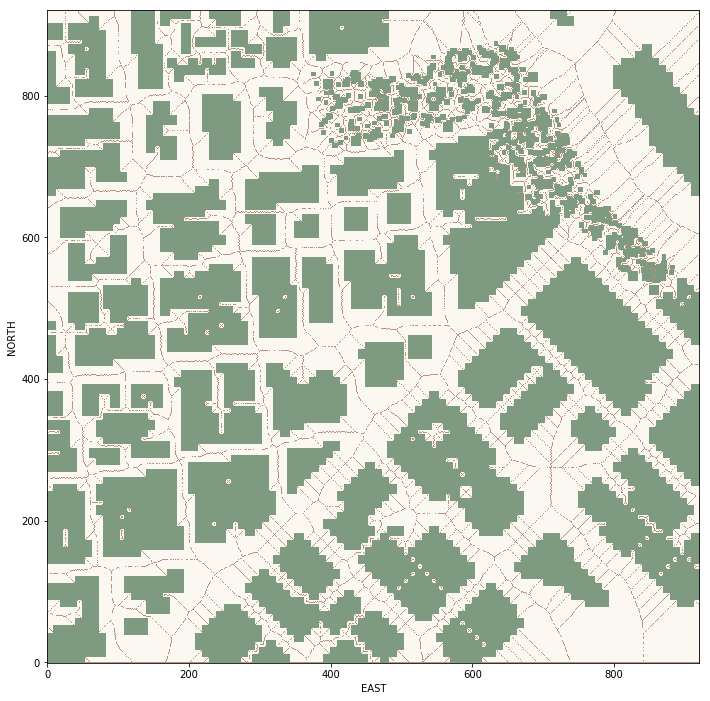

In [6]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, cmap='Greens', origin='lower')
plt.imshow(graph, cmap='Oranges', origin='lower', alpha=0.5)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Define and show start and goal postion

In [7]:
with open('colliders.csv', newline='') as f:
            reader = csv.reader(f)
            lat0, lon0 = next(reader)
            lat0= float(lat0[4:])
            lon0= float(lon0[6:])
        
#Done: set home position to (lon0, lat0, 0) --> out of drone.py
home_position=(lon0, lat0, 0.0)
global_home=(-122.39745,37.79248,0)

# Done: retrieve current global position
global_position = home_position

# Done: convert to current local position using global_to_local()
local_position =  global_to_local(global_position, global_home)

north_start = int(np.ceil(local_position[0]-north_offset))
east_start = int(np.ceil(local_position[1]-east_offset))

grid_start = (north_start, east_start)   


In [8]:
latitude_goal =  lat0+3.5e-3 # between -2.8e-3 and 5.3e-3
longitude_goal = lon0-2.9e-3 # between -5e-3 and 5.3e-3

goal_global = [ longitude_goal , latitude_goal , 0]
goal_local = global_to_local (goal_global,global_home)
         
north_goal = int(np.ceil(goal_local[0]-north_offset))
east_goal = int(np.ceil(goal_local[1]-east_offset))
        
grid_goal = (north_goal, east_goal)


graph_start, graph_goal = find_start_goal(graph, grid_start, grid_goal)

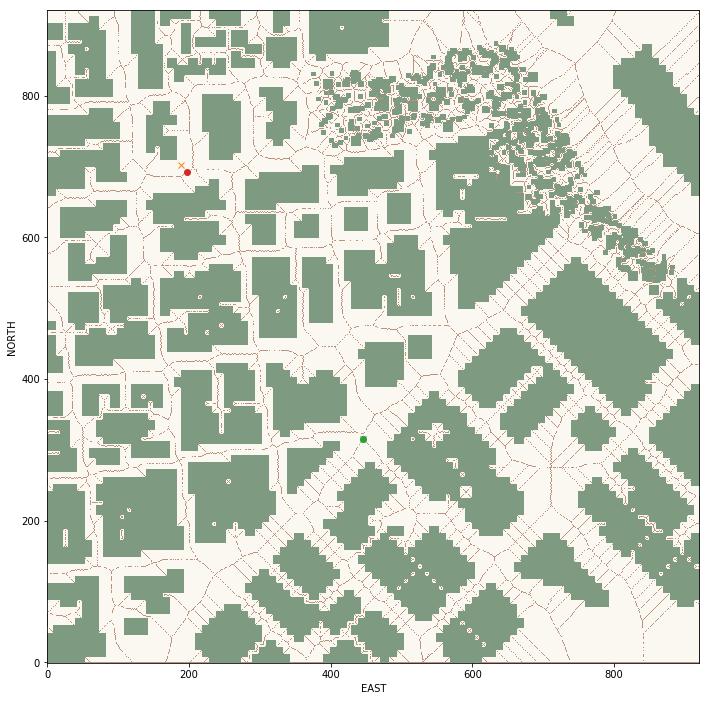

In [9]:
plt.imshow(grid, cmap='Greens', origin='lower')
plt.imshow(graph, cmap='Oranges', origin='lower', alpha=0.5)

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(grid_start[1], grid_start[0], 'x')
plt.plot(grid_goal[1], grid_goal[0], 'x')

plt.plot(graph_start[1], graph_start[0], 'o')
plt.plot(graph_goal[1], graph_goal[0], 'o')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Compute and show the lowest cost paths with A*. 

In [10]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic, grid_start, grid_goal)
print('grid path length: ',len(path), " & cost: ", np.round_(cost, decimals=2, out=None))

Found a path.
grid path length:  460  & cost:  539.77


In [11]:
path_graph, cost_graph = a_star(invert(graph).astype(np.int), heuristic, tuple(graph_start), tuple(graph_goal))
print('graph path length: ',len(path_graph), " & cost: ", np.round_(cost_graph, decimals=2, out=None))

Found a path.
graph path length:  535  & cost:  650.81


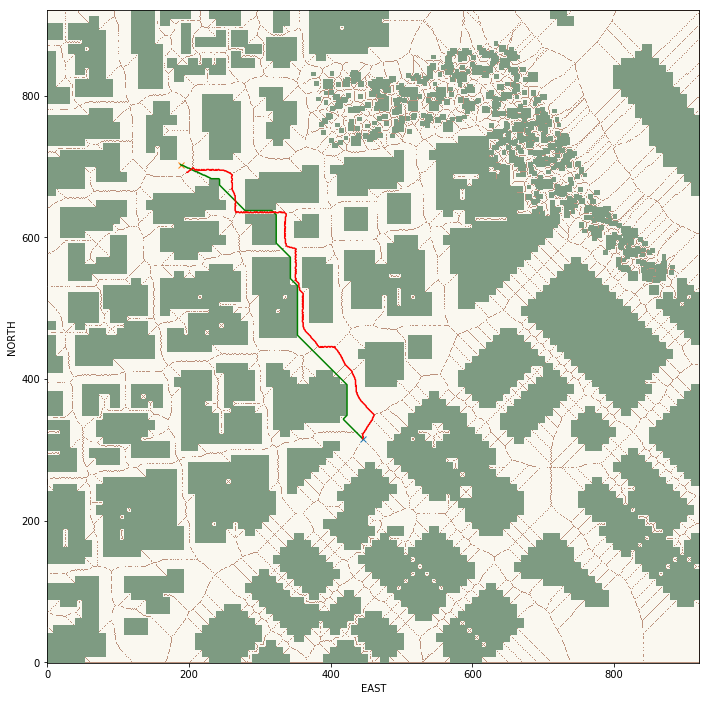

In [12]:
plt.imshow(grid, cmap='Greens', origin='lower')
plt.imshow(graph, cmap='Oranges', origin='lower', alpha=0.5)

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(grid_start[1], grid_start[0], 'x')
plt.plot(grid_goal[1], grid_goal[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    pp2 = np.array(path_graph)
    plt.plot(pp2[:, 1], pp2[:, 0], 'r')
    
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

This path is impractical, as the drone would at each waypoint. Better: consider only a new waypoint when the drone's direction changes. 

### Prune the paths and show results

In [13]:
pruned_path = prune_path(path,5)
print('pruned grid path: ',len(pruned_path))

pruned grid path:  20


As the path of the graph compared to the grid path is further away from obstacels there should be no problem to increase the epsilon value for the colinearty check to get less way points.

In [14]:
pruned_path_graph = prune_path(path_graph,30)
print('pruned graph path: ',len(pruned_path_graph))

pruned graph path:  17


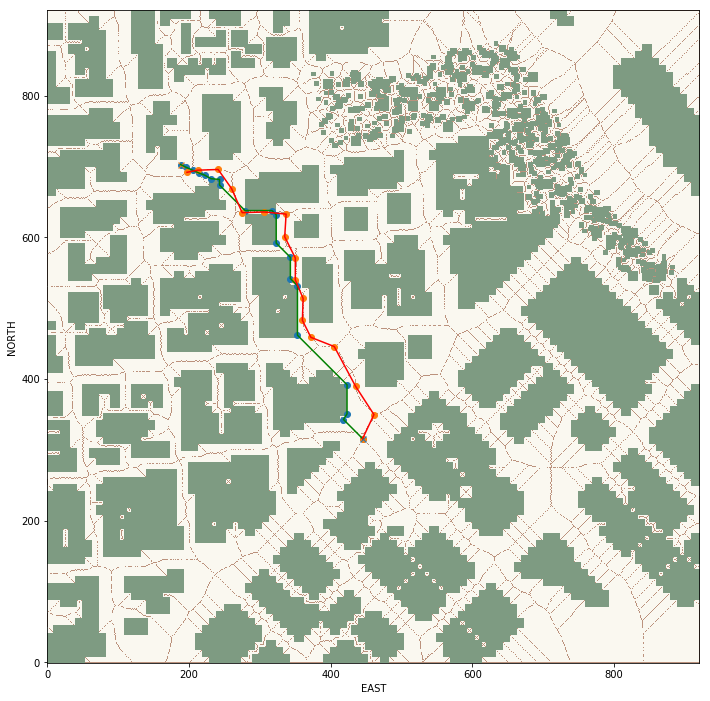

In [15]:
plt.imshow(grid, cmap='Greens', origin='lower')
plt.imshow(graph, cmap='Oranges', origin='lower', alpha=0.5)

plt.plot(grid_start[1], grid_start[0], 'x')
plt.plot(grid_goal[1], grid_goal[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])
    pp = np.array(pruned_path_graph)
    plt.plot(pp[:, 1], pp[:, 0], 'r')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!